### Introduction
Lets work through https://www.tensorflow.org/tutorials/image_retraining but using satellite jpg images I downloaded locally from https://sites.google.com/view/zhouwx/dataset?authuser=0. The retrain script is on https://github.com/tensorflow/hub/tree/master/examples/image_retraining (requires JPG, Tiff doesn't work). By default
it uses the feature vectors computed by Inception V3 trained on ImageNet, which is highly accurate, but comparatively large and slow. It's recommended to start with this to validate that you have gathered good training data, but if you want to deploy on resource-limited platforms, you can try the `--tfhub_module` flag with a Mobilenet model.

Useful ref: https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/#3

### The image dataset
PatternNet is a large-scale high-resolution remote sensing dataset collected for remote sensing image retrieval. There are 38 classes and each class has 800 images of size 256×256 pixels. The images in PatternNet are collected from Google Earth imagery or via the Google Map API for some US cities. The following table shows the classes and the corresponding spatial resolutions. The figure shows some example images from each class.

In [1]:
import glob
import os
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

In [2]:
data_path = "/Users/robincole/Documents/Data/PatternNet/Images"
retrain_script_path = "/Users/robincole/Documents/Github/tensorflow-hub/examples/image_retraining/retrain.py"

In [3]:
image_folders = os.listdir(data_path)
print("I have {} folders of images".format(len(image_folders)))
image_folders

I have 38 folders of images


['parking_space',
 'forest',
 'christmas_tree_farm',
 'tennis_court',
 'solar_panel',
 'basketball_court',
 'coastal_mansion',
 'river',
 'storage_tank',
 'nursing_home',
 'harbor',
 'oil_well',
 'ferry_terminal',
 'golf_course',
 'runway',
 'bridge',
 'oil_gas_field',
 'mobile_home_park',
 'overpass',
 'chaparral',
 'railway',
 'cemetery',
 'wastewater_treatment_plant',
 'baseball_field',
 'runway_marking',
 'intersection',
 'shipping_yard',
 'swimming_pool',
 'airplane',
 'sparse_residential',
 'parking_lot',
 'football_field',
 'beach',
 'dense_residential',
 'freeway',
 'crosswalk',
 'closed_road',
 'transformer_station']

In [4]:
print("Each folder has approximately {} images".format(len(os.path.join(data_path, image_folders[0]))))

Each folder has approximately 63 images


Lets plot one of the images

/Users/robincole/Documents/Data/PatternNet/Images/forest/forest083.jpg
(256, 256, 3)


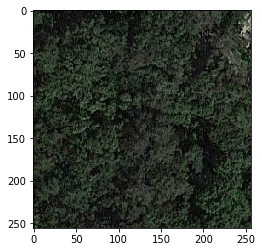

In [5]:
img_path = glob.glob(data_path + '/forest/*', recursive=True)[0]
print(img_path)
img = plt.imread(img_path)
print(img.shape)
plt.imshow(img);

## Perform the transfer learning

The `retrain.py` script will take care of splitting data into test/train/validate. Execute retrain with the following:

In [6]:
run_command_str = "python3 {} --image_dir {}".format(retrain_script_path, data_path)
print(run_command_str)

python3 /Users/robincole/Documents/Github/tensorflow-hub/examples/image_retraining/retrain.py --image_dir /Users/robincole/Documents/Data/PatternNet/Images


## Evaluate training

Start retrain at 11:55, finished at 14:27, so approximately 2.5 hours. 
Visualize the summaries with this command: 

`tensorboard --logdir /tmp/retrain_logs`

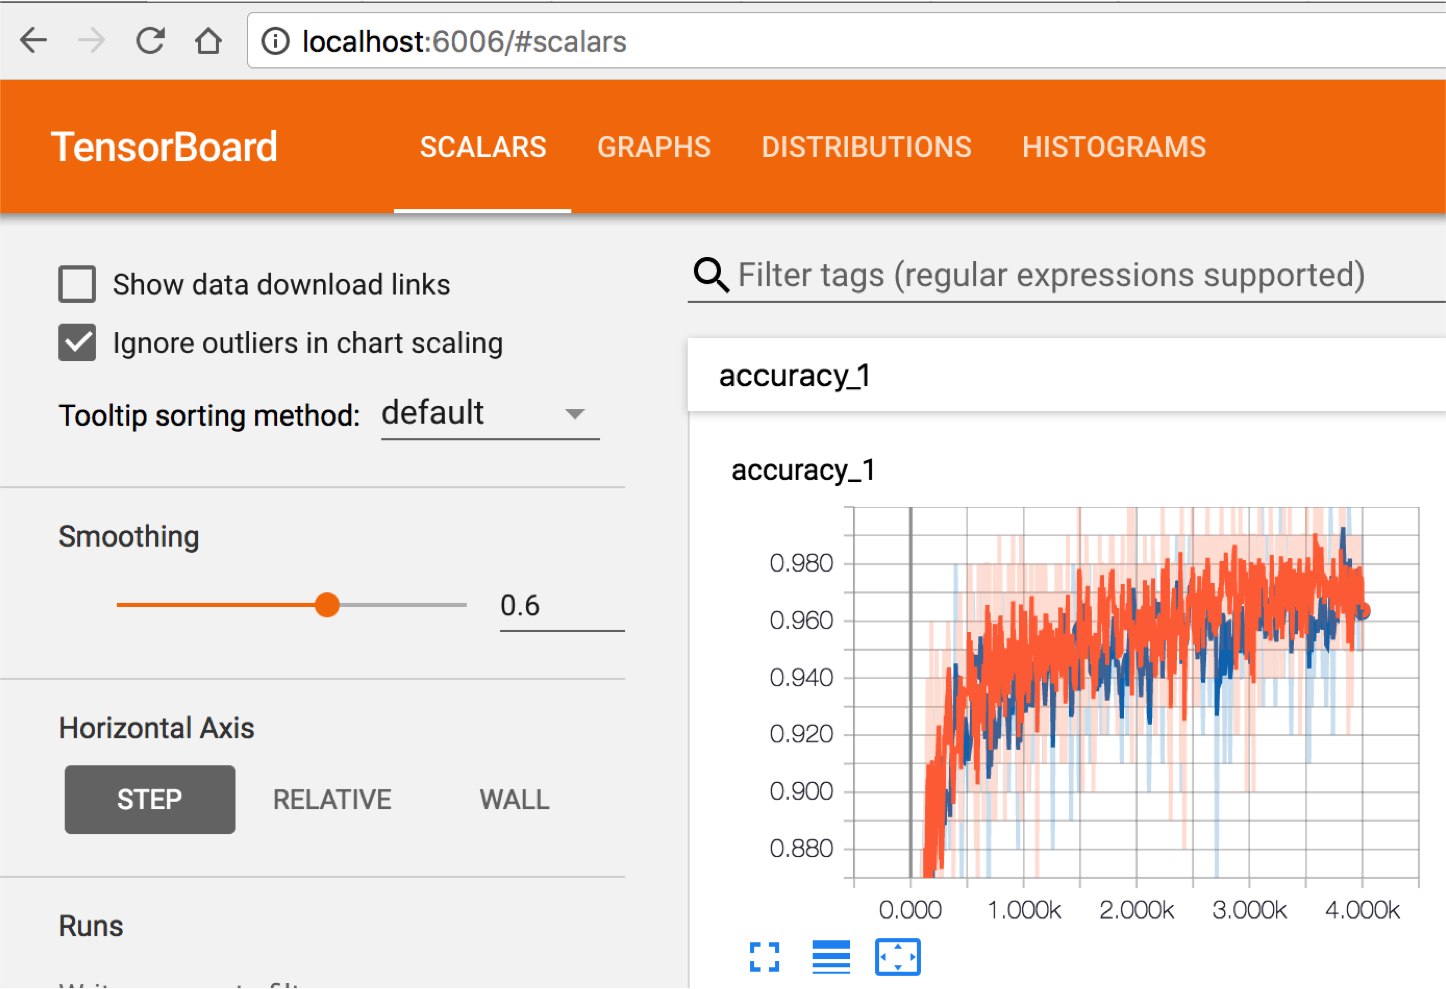

In [7]:
Image("../resources/tensorboard.png", width=800)

The training accuracy shows the percentage of the images used in the current training batch that were labeled with the correct class.

The validation accuracy is the precision (percentage of correctly-labelled images) on a randomly-selected group of images from a different set.

Lets get the final train and validation data:

In [8]:
train_accuracy = pd.read_csv("../resources/run_train-tag-accuracy_1.csv")

In [9]:
validation_accuracy = pd.read_csv("../resources/run_validation-tag-accuracy_1.csv")

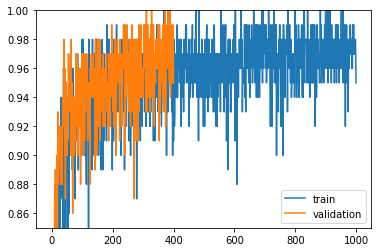

In [10]:
plt.plot(train_accuracy['Value'], label='train')
plt.plot(validation_accuracy['Value'], label='validation')
plt.ylim((0.85, 1.0))
plt.legend();

In [11]:
model_path = "/Users/robincole/Documents/Data/PatternNet/inception_v3/output_graph.pb"
file_size = int(os.stat(model_path).st_size/1e6)
print("The generated model (`.pb`) file is {} MB".format(file_size))

The generated model (`.pb`) file is 87 MB


In [12]:
labels_path = "/Users/robincole/Documents/Data/PatternNet/inception_v3/output_labels.txt"
labels = []
with open(labels_path) as f:
    for line in f:
        labels.append(line.strip('\n'))

print("The number of labels is {} and we expected {}".format(len(labels), len(image_folders)))

The number of labels is 38 and we expected 38


We can serve the model with

`tensorflow_model_server --port=9000 --model_name=my_image_classifier --model_base_path=/Users/robincole/Documents/Data/PatternNet`

ERROR `tensorflow_model_server: command not found`

## Using the model

We now use the model using `label_image.py` from https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/label_image/label_image.py

In [13]:
poets_folder = "/Users/robincole/Documents/Github/tensorflow-for-poets-2/scripts"
os.listdir(poets_folder)

['graph_pb2tb.py',
 'quantize_graph.py',
 'retrain.py',
 'label_image.py',
 '__init__.py',
 'show_image.py',
 'evaluate.py',
 'count_ops.py']

The command we require is:

In [14]:
"python3 {} --image={} --graph={} --labels={} --input_layer=Placeholder --output_layer=final_result".format("label_image.py", img_path, model_path, labels_path) #  --output_layer=final_result:0

'python3 label_image.py --image=/Users/robincole/Documents/Data/PatternNet/Images/forest/forest083.jpg --graph=/Users/robincole/Documents/Data/PatternNet/inception_v3/output_graph.pb --labels=/Users/robincole/Documents/Data/PatternNet/inception_v3/output_labels.txt --input_layer=Placeholder --output_layer=final_result'

Response is:
```
forest 0.9981623
river 0.00075750035
sparse residential 0.00010027897
oil gas field 8.9558e-05
railway 8.550265e-05
```